# Anti-Cancer Drug Activity Prediction

## Task 1  Meme competition
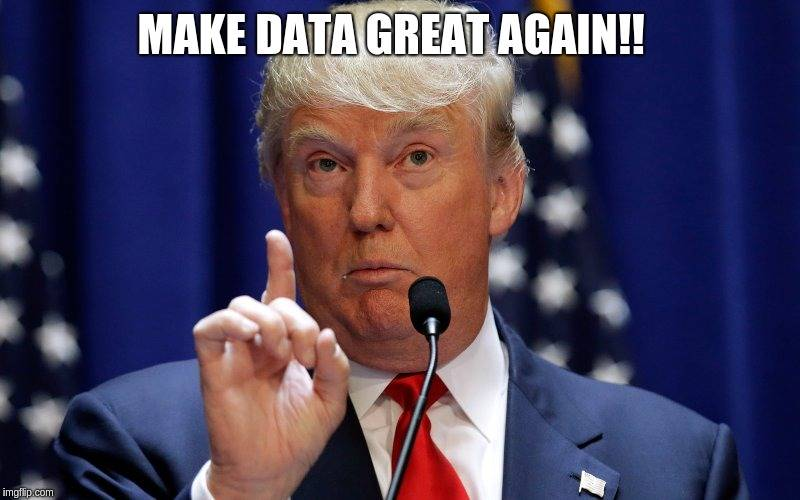

##  Task2 Problem Formulation

**What is the input? What is the output?**

The input to the model is a graph, which includes nodes representing chemical elements, edges for constructing the structure, and labels for binary classification.

The output of the model is a 0/1 binary prediction for againsting cancer cell, 1 for possitive and 0 for negative.

**What data mining function is required?**

The model serves primarily as a binary classifier. Initially, a dataloader for loading graph data and batching the training data. The processing pipeline embeds the node information and then upsamples the training data to rebalance the data. finally the GNN aggregation approach is employed to provide the binary prediction result.

**What could be the challenges?**

The challenging part would be resolving the imbalanced data to enhance model performance.

**What is the impact?**

The trained model can help in predicting if a novel chemical compound can effectively cure cancer, hence reducing considerable costs associated with new medical research.

**What is an ideal solution?**

the ideal solution would consist of upsampling the positive samples to address data imbalance and embedding node information,  followed by fine tuning to improve the GNN model's performance.


## Task 3 Understanding the template

In [54]:
from google.colab import drive # connet to google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
#importing libraries
import numpy as np
from tqdm.notebook import tqdm
# read in sdf data
def read_sdf(file):
    with open(file, 'r') as rf: #opening the file
        content = rf.read()  #reading the contents in the file
    samples = content.split('$$$$')  # Split the read file by $$$$ 
    # function to config each parse sample
    def parse_sample(s): 
        lines = s.splitlines() #split the text data into lines
        links = []
        nodes = []
        label = 0
        #loop over each line
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
                #for nodes
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label #return nodes, edge and label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                

In [56]:
from sklearn.model_selection import train_test_split # import library

training_set = read_sdf('/content/drive/MyDrive/a6/train.sdf') # read in traning data

training_set, validation_set = train_test_split(training_set, test_size=0.15,) # split traning and testing data

  0%|          | 0/25024 [00:00<?, ?it/s]

In [57]:
testing_set  = read_sdf('/content/drive/MyDrive/a6/test_x.sdf')# read in testing data 

  0%|          | 0/12326 [00:00<?, ?it/s]

In [58]:
print(training_set[1]) #print one sample

(['O', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0, 12],
       [ 0, 20],
       [ 1, 10],
       [ 2, 12],
       [ 3, 19],
       [ 3, 21],
       [ 4, 19],
       [ 5, 10],
       [ 5, 11],
       [ 6,  7],
       [ 6, 15],
       [ 7,  8],
       [ 8, 23],
       [ 8, 24],
       [ 9, 10],
       [ 9, 13],
       [ 9, 14],
       [11, 12],
       [11, 16],
       [13, 17],
       [14, 18],
       [15, 17],
       [15, 18],
       [16, 19],
       [20, 22],
       [21, 25]]), 0)


Visualizing/Inspecting a Sample

In [59]:
#import libraries
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [60]:
# visualize the compound graph 
def visualize(sample):
    G=nx.Graph() #initiating an instance of graph
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
     #create array for each node color
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
     #drawing the graph sample with the label
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G #returns graph

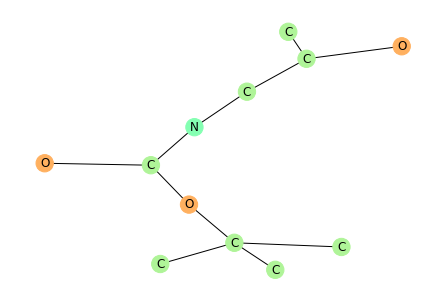

In [61]:
plt.clf() #plot one sample
visualize(training_set[20])

Preprocessing:

In [62]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500 #vocabulary size
max_len = 100 # maximum length of the tokenizer

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes) #training tokenizer

In [63]:
#import libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0) # set random seed

# prepare single batch of the data
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples] # Nodes characters 
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # tokenizing the sample nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post') # pad_sequences for each sample
    max_nodes_len = np.shape(sample_nodes)[1] #get the shape
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]# indexing current nodes
    edges = [e for e in edges if len(e) > 0] #check the element is non-zero
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create segmented_ids
    
    all_nodes = np.reshape(sample_nodes, -1) #reshape the nodes of all samples 
    all_edges = np.concatenate(edges)  #concatenate edges of all samples

    node_to_graph = np.reshape(node_to_graph, -1)
    return { #returns a dictionary of features
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


#generating batch
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True: # loop over
        dataset = list(dataset) #data in the array
        if shuffle: # if shuffle is True
            random.shuffle(dataset) #randomly shuffle
        l = len(dataset) #length of dataset
        for ndx in range(0, l, batch_size): #loop over for creating batches 
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] #creating batch samples
            yield prepare_single_batch(batch_samples) #call prepare_single_batch 
        if not repeat: #breaking loop 
            break


In [64]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k) #k: labels
        print(v) #v: values
        pass
    print('label', train_batch[1])
    break
    

data
[5 8 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 4
 4 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 8 2 2 2
 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 2 2 3
 3 3 3 3 3 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0   5]
 [  1   2]
 [  1   3]
 [  1   8]
 [  1   9]
 [  2  11]
 [  4   6]
 [  5   6]
 [  5   7]
 [  6   8]
 [  7   9]
 [  7  10]
 [ 11  12]
 [ 35  51]
 [ 36  38]
 [ 36  39]
 [ 36  40]
 [ 36  45]
 [ 37  47]
 [ 40  46]
 [ 41  46]
 [ 41  53]
 [ 41  54]
 [ 42  55]
 [ 42  61]
 [ 42  62]
 [ 43  58]
 [ 44  59]
 [ 45  47]
 [ 45  48]
 [ 46  50]
 [ 47  52]
 [ 48  49]
 [ 49  51]
 [ 49  60]
 [ 50  58]
 [ 50  59]
 [ 51  52]
 [ 53  56]
 [ 54  57]
 [ 55  56]
 [ 55  57]
 [ 70  71]
 [ 70  72]
 [ 70  73]
 [ 70  74]
 [ 71  80]
 [ 72  81]
 [ 75  79]
 [ 75  85]
 [ 76  84]
 [ 77  83]
 [ 77  86]
 [ 77  87]
 [ 77  88]
 [ 78  82]
 [ 78  84]
 [ 79  80]
 [ 79  82]
 [ 81  83]
 [ 84  89]
 [ 85  91]
 [ 89  90]
 [ 90  92]


In [65]:
!pip install --quiet tf2_gnn #installing tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput #import the model

In [66]:
#import libraries
import tensorflow as tf
from tensorflow.math import segment_mean # the mean of elements in segments of a tensor.
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
params["hidden_dim"] = 32 #change default hyperparameters
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []        

In [67]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

In [68]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data
# fit in the data
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large am

1330/1330 [==============================] - 22s 15ms/step - loss: 0.2377 - auc: 0.4554 - val_loss: 0.1916 - val_auc: 0.6511
Epoch 2/5
1330/1330 [==============================] - 16s 12ms/step - loss: 0.1967 - auc: 0.6154 - val_loss: 0.1878 - val_auc: 0.6805
Epoch 3/5
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1941 - auc: 0.6421 - val_loss: 0.1790 - val_auc: 0.7109
Epoch 4/5
1330/1330 [==============================] - 14s 11ms/step - loss: 0.1902 - auc: 0.6661 - val_loss: 0.1791 - val_auc: 0.7049
Epoch 5/5
1330/1330 [==============================] - 14s 11ms/step - loss: 0.1887 - auc: 0.6661 - val_loss: 0.1836 - val_auc: 0.7191


In [69]:
y_pred = model.predict( # generate prediction using trained model
    gen_batch(testing_set, batch_size=16, shuffle=False)
) 
y_pred = np.reshape(y_pred, -1) #reshap the prediction

771/771 [==============================] - 3s 4ms/step


In [70]:
len(y_pred)#print lenght

12326

In [71]:
import pandas as pd # prepare csv file for submision
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission.csv')

## Task 4 Model Tuning

### Tiral 1-2 tuning the templet model

Observing the previous training results, it is clear that the model requires improvement; thus, I want to conduct two separate trials with rising and decreasing model complexity to evaluate its performance.In adition, I plan to increase the number of traning epochs. 

In [72]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters
params["hidden_dim"] = 64 
params["num_layers"] = 16
params["dense_every_num_layers"] = 8
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 12
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model1.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_10/SegmentMean:0', description="created by layer 'tf.math.segment_mean_10'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None,)]            0           [] 

In [73]:
model1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data
# fit in the data
model1.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_15_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_15_grad/gradients/grad_ys_0_values:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_15_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_15_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_15_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_15_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consu

1330/1330 [==============================] - 39s 24ms/step - loss: 0.3029 - auc: 0.4407 - val_loss: 0.2424 - val_auc: 0.4739
Epoch 2/10
1330/1330 [==============================] - 26s 19ms/step - loss: 0.2367 - auc: 0.4440 - val_loss: 0.2226 - val_auc: 0.4284
Epoch 3/10
1330/1330 [==============================] - 25s 19ms/step - loss: 0.2114 - auc: 0.4481 - val_loss: 0.1943 - val_auc: 0.5242
Epoch 4/10
1330/1330 [==============================] - 26s 19ms/step - loss: 0.2018 - auc: 0.4456 - val_loss: 0.1960 - val_auc: 0.4971
Epoch 5/10
1330/1330 [==============================] - 25s 19ms/step - loss: 0.2039 - auc: 0.4754 - val_loss: 0.1958 - val_auc: 0.5631
Epoch 6/10
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1974 - auc: 0.4905 - val_loss: 0.1920 - val_auc: 0.4824
Epoch 7/10
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1993 - auc: 0.5350 - val_loss: 0.1897 - val_auc: 0.5663
Epoch 8/10
1330/1330 [==============================] - 26s

In [74]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model1_2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model1_2.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           [] 

In [75]:
model1_2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data
# fit in the data
model1_2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
1330/1330 [==============================] - 17s 11ms/step - loss: 0.2089 - auc: 0.5623 - val_loss: 0.1888 - val_auc: 0.6426
Epoch 2/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.1894 - auc: 0.6315 - val_loss: 0.1834 - val_auc: 0.6783
Epoch 3/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.1893 - auc: 0.6320 - val_loss: 0.1939 - val_auc: 0.6777
Epoch 4/20
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1872 - auc: 0.6555 - val_loss: 0.1876 - val_auc: 0.6737
Epoch 5/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.1874 - auc: 0.6488 - val_loss: 0.1802 - val_auc: 0.6994
Epoch 6/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.1873 - auc: 0.6602 - val_loss: 0.1753 - val_auc: 0.7097
Epoch 7/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.1852 - auc: 0.6741 - val_loss: 0.1853 - val_auc: 0.7080
Epoch 8/20
1330/1330 [==========================

### tiral 2  up-sample the positive class samples 

The prior training result reveals no significant improvement over the model. So we plan to  up-sample the positive class samples to rebalance the data.

In [76]:
from sklearn.model_selection import train_test_split # import library

training_set = read_sdf('/content/drive/MyDrive/a6/train.sdf') # read in traning data

training_set, validation_set = train_test_split(training_set, test_size=0.15,) # split traning and testing data

  0%|          | 0/25024 [00:00<?, ?it/s]

<ipython-input-77-7e8cd95110ed>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sns.countplot(np.array(training_set)[:,2]) # map the two classes' distribution
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


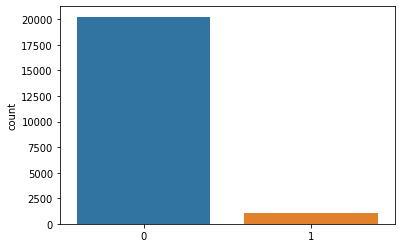

In [77]:
import seaborn as sns
sns.countplot(np.array(training_set)[:,2]) # map the two classes' distribution 
     

The summary plot shows that the training data is significantly  imbalanced. the number of sample with 0 label is approximately 20 times that of samples with label.

In [78]:
train_neg =[i for i in training_set if i[2] ==0] # loop over to get all 0class samples from training_set
train_pos =[i for i in training_set if i[2] ==1] # loop over to get all 1class samples from training_set
print(len(train_neg))
print(len(train_pos))

20247
1023


In [79]:
from sklearn.utils import resample 
train_pos = resample(train_pos, replace=True, n_samples=len(train_neg))
print(len(train_neg))
print(len(train_pos))

20247
20247


In [80]:
tranin_upsampling= train_neg + train_pos # concatenate the positive and negtive samples

<ipython-input-81-560ec66e607d>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sns.countplot(np.array(tranin_upsampling)[:,2])  # map the two classes' distribution
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


40494


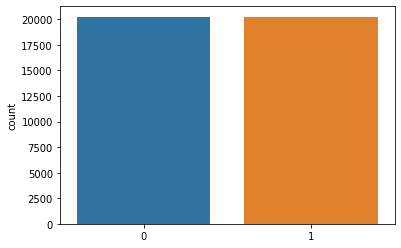

In [81]:
print(len(tranin_upsampling))
import seaborn as sns
sns.countplot(np.array(tranin_upsampling)[:,2])  # map the two classes' distribution 

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model2_1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model2_1.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

In [ ]:
model2_1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data
# fit in the data
model2_1.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a l

1330/1330 [==============================] - 17s 11ms/step - loss: 0.6615 - auc: 0.6289 - val_loss: 0.7346 - val_auc: 0.6298
Epoch 2/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.6441 - auc: 0.6667 - val_loss: 0.5740 - val_auc: 0.6318
Epoch 3/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.6280 - auc: 0.6908 - val_loss: 0.7013 - val_auc: 0.7004
Epoch 4/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.6179 - auc: 0.7144 - val_loss: 0.7115 - val_auc: 0.6997
Epoch 5/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.6126 - auc: 0.7228 - val_loss: 0.5910 - val_auc: 0.7104
Epoch 6/20
1330/1330 [==============================] - 14s 11ms/step - loss: 0.6103 - auc: 0.7221 - val_loss: 0.6310 - val_auc: 0.7027
Epoch 7/20
1330/1330 [==============================] - 15s 11ms/step - loss: 0.6013 - auc: 0.7347 - val_loss: 0.6977 - val_auc: 0.7135
Epoch 8/20
1330/1330 [==============================] - 15s

### trial 3-4 Class Weighs

The upsampling strategy appears to have enhanced the model's performance. The drawback of this method is that it generates a large number of repeated samples in the training data. Instead, let's use the original training data but give the minority class greater weight when calculating the loss.

In [ ]:
from sklearn.model_selection import train_test_split # import library

training_set = read_sdf('/content/drive/MyDrive/a6/train.sdf') # read in traning data

training_set, validation_set = train_test_split(training_set, test_size=0.15,) # split traning and testing data

  0%|          | 0/25024 [00:00<?, ?it/s]

<ipython-input-34-b056b9c74403>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sns.countplot(np.array(training_set)[:,2]) # map the two classes' distribution
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


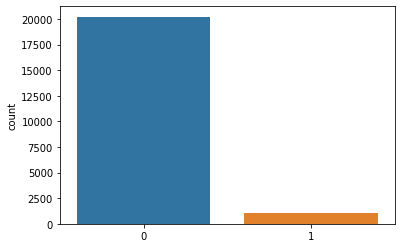

In [ ]:
import seaborn as sns
sns.countplot(np.array(training_set)[:,2]) # map the two classes' distribution 

In [ ]:
train_neg =[i for i in training_set if i[2] ==0] # loop over to get all the 0 class samples from the dataset
train_pos =[i for i in training_set if i[2] ==1] # loop over to get all the 1 class samples from the dataset
print(len(train_neg))
print(len(train_pos))

20226
1044


In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model3.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [ ]:
model3.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
) 

Epoch 1/10
1330/1330 [==============================] - 16s 11ms/step - loss: 1.2660 - auc: 0.6459 - val_loss: 0.6171 - val_auc: 0.6381
Epoch 2/10
1330/1330 [==============================] - 14s 11ms/step - loss: 1.2608 - auc: 0.6444 - val_loss: 0.7005 - val_auc: 0.6582
Epoch 3/10
1330/1330 [==============================] - 14s 11ms/step - loss: 1.2717 - auc: 0.6358 - val_loss: 0.5725 - val_auc: 0.6170
Epoch 4/10
1330/1330 [==============================] - 14s 11ms/step - loss: 1.2719 - auc: 0.6447 - val_loss: 0.5549 - val_auc: 0.6204
Epoch 5/10
1330/1330 [==============================] - 14s 11ms/step - loss: 1.2739 - auc: 0.6402 - val_loss: 0.7609 - val_auc: 0.6211
Epoch 6/10
1330/1330 [==============================] - 14s 11ms/step - loss: 1.2641 - auc: 0.6455 - val_loss: 0.6338 - val_auc: 0.6748
Epoch 7/10
1330/1330 [==============================] - 14s 11ms/step - loss: 1.2627 - auc: 0.6475 - val_loss: 0.5515 - val_auc: 0.6095
Epoch 8/10
1330/1330 [==========================

It appears that this strategy significantly improves the model's performance. Let's experiment with upsampling and class weights to see how they affect the model. 

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model3_2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model3_2.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

In [ ]:
model3_2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model3_2.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
) 

Epoch 1/20
1330/1330 [==============================] - 17s 11ms/step - loss: 2.0860 - auc: 0.6278 - val_loss: 3.3162 - val_auc: 0.6823
Epoch 2/20
1330/1330 [==============================] - 14s 11ms/step - loss: 1.8972 - auc: 0.6845 - val_loss: 3.6011 - val_auc: 0.6884
Epoch 3/20
1330/1330 [==============================] - 14s 11ms/step - loss: 1.8887 - auc: 0.6990 - val_loss: 3.3881 - val_auc: 0.7202
Epoch 4/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8671 - auc: 0.7038 - val_loss: 3.2647 - val_auc: 0.7300
Epoch 5/20
1330/1330 [==============================] - 15s 11ms/step - loss: 1.8345 - auc: 0.7297 - val_loss: 3.0172 - val_auc: 0.7725
Epoch 6/20
1330/1330 [==============================] - 14s 11ms/step - loss: 1.8301 - auc: 0.7357 - val_loss: 2.7025 - val_auc: 0.7795
Epoch 7/20
1330/1330 [==============================] - 14s 11ms/step - loss: 1.8093 - auc: 0.7403 - val_loss: 2.9601 - val_auc: 0.7667
Epoch 8/20
1330/1330 [==========================

It appears that combining upsampling and class weights has considerably enhanced the model's performance to 80% above.

### Trial 5-10 Different GCN aggregation mechanisms

According to the prior training results, both upsampling and the class weights strategy significantly enhanced the model's performance. Let's experiment with different GCN aggregation mechanisms to observe how they affect model performance. 



In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput #import the model
from  tf2_gnn.layers.message_passing import gnn_edge_mlp,gnn_film,rgat,rgin,rgcn,ggnn # import GCN aggregation mechanisms

#### GGNN

Gated Graph Neural Networks

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model4_1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4_1.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

In [ ]:
model4_1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model4_1.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of

1330/1330 [==============================] - 23s 15ms/step - loss: 1.9973 - auc: 0.6404 - val_loss: 2.9266 - val_auc: 0.7154
Epoch 2/20
1330/1330 [==============================] - 19s 14ms/step - loss: 1.8901 - auc: 0.6867 - val_loss: 2.3202 - val_auc: 0.7079
Epoch 3/20
1330/1330 [==============================] - 19s 14ms/step - loss: 1.8599 - auc: 0.7024 - val_loss: 3.0713 - val_auc: 0.7413
Epoch 4/20
1330/1330 [==============================] - 19s 15ms/step - loss: 1.8518 - auc: 0.7095 - val_loss: 2.8798 - val_auc: 0.7481
Epoch 5/20
1330/1330 [==============================] - 19s 14ms/step - loss: 1.8541 - auc: 0.7154 - val_loss: 2.9835 - val_auc: 0.7651
Epoch 6/20
1330/1330 [==============================] - 19s 14ms/step - loss: 1.8232 - auc: 0.7334 - val_loss: 2.7253 - val_auc: 0.7816
Epoch 7/20
1330/1330 [==============================] - 19s 14ms/step - loss: 1.8253 - auc: 0.7314 - val_loss: 2.5287 - val_auc: 0.7821
Epoch 8/20
1330/1330 [==============================] - 19s

#### RGCN

Relational Graph Convolutional Networks

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model4_2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4_2.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []        

In [ ]:
model4_2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model4_2.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20
1330/1330 [==============================] - 19s 12ms/step - loss: 2.0995 - auc: 0.6159 - val_loss: 3.0262 - val_auc: 0.6817
Epoch 2/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.9248 - auc: 0.6613 - val_loss: 3.2475 - val_auc: 0.6975
Epoch 3/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8939 - auc: 0.6857 - val_loss: 3.0468 - val_auc: 0.7192
Epoch 4/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8844 - auc: 0.7025 - val_loss: 2.9321 - val_auc: 0.7541
Epoch 5/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8440 - auc: 0.7215 - val_loss: 2.8413 - val_auc: 0.7669
Epoch 6/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8360 - auc: 0.7311 - val_loss: 2.7113 - val_auc: 0.7737
Epoch 7/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8261 - auc: 0.7363 - val_loss: 2.7099 - val_auc: 0.7702
Epoch 8/20
1330/1330 [==========================

#### RGAT

Relational Graph Attention Networks

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGAT'
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["num_heads"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model4_3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4_3.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []        

In [ ]:
import math

model4_3.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model4_3.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib

1330/1330 [==============================] - 32s 20ms/step - loss: 2.0698 - auc: 0.6254 - val_loss: 3.1305 - val_auc: 0.6684
Epoch 2/20
1330/1330 [==============================] - 27s 20ms/step - loss: 1.9108 - auc: 0.6758 - val_loss: 3.0976 - val_auc: 0.7078
Epoch 3/20
1330/1330 [==============================] - 27s 20ms/step - loss: 1.8777 - auc: 0.7018 - val_loss: 3.0542 - val_auc: 0.7317
Epoch 4/20
1330/1330 [==============================] - 28s 21ms/step - loss: 1.8413 - auc: 0.7243 - val_loss: 2.8739 - val_auc: 0.7601
Epoch 5/20
1330/1330 [==============================] - 27s 20ms/step - loss: 1.8178 - auc: 0.7390 - val_loss: 2.5251 - val_auc: 0.7694
Epoch 6/20
1330/1330 [==============================] - 27s 20ms/step - loss: 1.8007 - auc: 0.7547 - val_loss: 2.8450 - val_auc: 0.7888
Epoch 7/20
1330/1330 [==============================] - 28s 21ms/step - loss: 1.7942 - auc: 0.7563 - val_loss: 2.5547 - val_auc: 0.7928
Epoch 8/20
1330/1330 [==============================] - 27s

#### RGIN

Relational Graph Isomorphism Networks

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGIN'
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["num_aggr_MLP_hidden_layers"]=4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model4_4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4_4.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []        

In [52]:
model4_4.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model4_4.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/rgin/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unkno

1330/1330 [==============================] - 73s 15ms/step - loss: 2.0373 - auc: 0.6347 - val_loss: 2.8772 - val_auc: 0.6766
Epoch 2/20
1330/1330 [==============================] - 18s 14ms/step - loss: 1.9115 - auc: 0.6680 - val_loss: 2.6951 - val_auc: 0.6824
Epoch 3/20
1330/1330 [==============================] - 17s 13ms/step - loss: 1.8946 - auc: 0.6839 - val_loss: 3.1600 - val_auc: 0.6901
Epoch 4/20
1330/1330 [==============================] - 19s 14ms/step - loss: 1.9127 - auc: 0.6769 - val_loss: 3.0322 - val_auc: 0.6898
Epoch 5/20
1330/1330 [==============================] - 20s 15ms/step - loss: 1.8925 - auc: 0.6921 - val_loss: 2.5830 - val_auc: 0.7378
Epoch 6/20
1330/1330 [==============================] - 19s 14ms/step - loss: 1.8660 - auc: 0.7120 - val_loss: 2.6553 - val_auc: 0.7389
Epoch 7/20
1330/1330 [==============================] - 17s 13ms/step - loss: 1.8890 - auc: 0.7102 - val_loss: 2.9937 - val_auc: 0.7073
Epoch 8/20
1330/1330 [==============================] - 18s

#### GNN-Edge-MLP

Graph Neural Network with Edge MLPs - a variant of RGCN in which messages on edges are computed using full MLPs, not just a single layer applied to the source state.

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'gnn_edge_mlp'
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["num_aggr_MLP_hidden_layers"]=4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model4_4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4_4.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []        

In [ ]:
model4_4.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model4_4.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp/embedding_lookup_grad/Cast:0",

1330/1330 [==============================] - 19s 13ms/step - loss: 2.0718 - auc: 0.6210 - val_loss: 3.0142 - val_auc: 0.7135
Epoch 2/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.9120 - auc: 0.6688 - val_loss: 3.1646 - val_auc: 0.7015
Epoch 3/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8896 - auc: 0.6916 - val_loss: 2.8806 - val_auc: 0.7506
Epoch 4/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8603 - auc: 0.7094 - val_loss: 2.7856 - val_auc: 0.7541
Epoch 5/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8462 - auc: 0.7227 - val_loss: 2.8868 - val_auc: 0.7506
Epoch 6/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8545 - auc: 0.7230 - val_loss: 2.9851 - val_auc: 0.7317
Epoch 7/20
1330/1330 [==============================] - 16s 12ms/step - loss: 1.8309 - auc: 0.7283 - val_loss: 2.8014 - val_auc: 0.7499
Epoch 8/20
1330/1330 [==============================] - 16s

#### GNN-FiLM

Graph Neural Networks with Feature-wise Linear Modulation (Brockschmidt, 2019) - a new extension of RGCN with FiLM layers.

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'gnn_film'
params["film_parameter_MLP_hidden_layers"]=12
params["hidden_dim"] = 16 
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["num_aggr_MLP_hidden_layers"]=4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model4_5 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4_5.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_10/SegmentMean:0', description="created by layer 'tf.math.segment_mean_10'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None,)]            0           [] 

In [ ]:
model4_5.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model4_5.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__fi_lm/embedding_lookup_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__fi_lm/embedding_lookup_1_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume

1330/1330 [==============================] - 33s 20ms/step - loss: 2.0125 - auc: 0.6200 - val_loss: 3.0113 - val_auc: 0.7648
Epoch 2/20
1330/1330 [==============================] - 26s 20ms/step - loss: 1.8923 - auc: 0.6900 - val_loss: 3.1562 - val_auc: 0.7464
Epoch 3/20
1330/1330 [==============================] - 26s 20ms/step - loss: 1.8687 - auc: 0.7149 - val_loss: 2.4193 - val_auc: 0.7150
Epoch 4/20
1330/1330 [==============================] - 26s 20ms/step - loss: 1.8752 - auc: 0.7096 - val_loss: 2.7184 - val_auc: 0.7526
Epoch 5/20
1330/1330 [==============================] - 26s 20ms/step - loss: 1.8572 - auc: 0.7181 - val_loss: 2.7255 - val_auc: 0.7639
Epoch 6/20
1330/1330 [==============================] - 27s 20ms/step - loss: 1.8555 - auc: 0.7153 - val_loss: 3.0711 - val_auc: 0.7787
Epoch 7/20
1330/1330 [==============================] - 26s 20ms/step - loss: 1.8576 - auc: 0.7258 - val_loss: 3.1529 - val_auc: 0.7918
Epoch 8/20
1330/1330 [==============================] - 27s

### Trial 11-13  Different global_exchange_mode

Based on the prior training results, we can conclude that RGAT is the optimal aggregation mechanism and that it improves the model's performance. Let's try RGAT with different global exchange modes. See how it affects the model's performance. 

#### mean

mean just computes the arithmetic mean of the node and graph-level representation

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGAT'
params["global_exchange_mode"] = 'mean'
params["hidden_dim"] = 16 
params["num_heads"] = 4
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["num_aggr_MLP_hidden_layers"]=4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model5_1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model5_1.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           [] 

In [ ]:
model5_1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data
 
cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model5_1.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20
1330/1330 [==============================] - 33s 22ms/step - loss: 2.3015 - auc: 0.5992 - val_loss: 2.5761 - val_auc: 0.6649
Epoch 2/20
1330/1330 [==============================] - 28s 21ms/step - loss: 1.9525 - auc: 0.6492 - val_loss: 2.3131 - val_auc: 0.7107
Epoch 3/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.9173 - auc: 0.6655 - val_loss: 2.6079 - val_auc: 0.7266
Epoch 4/20
1330/1330 [==============================] - 29s 21ms/step - loss: 1.9034 - auc: 0.6877 - val_loss: 2.7362 - val_auc: 0.7372
Epoch 5/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8699 - auc: 0.7111 - val_loss: 2.2308 - val_auc: 0.7662
Epoch 6/20
1330/1330 [==============================] - 29s 21ms/step - loss: 1.8735 - auc: 0.7135 - val_loss: 2.3407 - val_auc: 0.7531
Epoch 7/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8639 - auc: 0.7203 - val_loss: 2.3209 - val_auc: 0.7635
Epoch 8/20
1330/1330 [==========================

#### mlp

mlp computes a new representation using an MLP that gets the concatenation of node and graph level representations as input.

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGAT'
params["global_exchange_mode"] = 'mlp'
params["hidden_dim"] = 16 
params["num_heads"] = 4
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["num_aggr_MLP_hidden_layers"]=4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model5_2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model5_2.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_12/StatefulPartitionedCall:0', description="created by layer 'gnn_12'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_12/SegmentMean:0', description="created by layer 'tf.math.segment_mean_12'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_12/Sigmoid:0', description="created by layer 'dense_12'")
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None,)]            0           [] 

In [ ]:
model5_2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data
 
cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model5_2.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20
1330/1330 [==============================] - 34s 22ms/step - loss: 2.2930 - auc: 0.6101 - val_loss: 2.5171 - val_auc: 0.6827
Epoch 2/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.9163 - auc: 0.6675 - val_loss: 2.7077 - val_auc: 0.7184
Epoch 3/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8784 - auc: 0.7036 - val_loss: 2.4784 - val_auc: 0.7317
Epoch 4/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8702 - auc: 0.7106 - val_loss: 2.5628 - val_auc: 0.7577
Epoch 5/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8750 - auc: 0.7137 - val_loss: 2.7002 - val_auc: 0.7558
Epoch 6/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8588 - auc: 0.7270 - val_loss: 2.7176 - val_auc: 0.7560
Epoch 7/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8590 - auc: 0.7339 - val_loss: 2.3901 - val_auc: 0.7604
Epoch 8/20
1330/1330 [==========================

#### gru

gru uses a GRU cell that gets the old node representation as state and the graph representation as input.

In [ ]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGAT'
params["global_exchange_mode"] = 'gru'
params["hidden_dim"] = 16 
params["num_heads"] = 4
params["num_layers"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
params["global_exchange_every_num_layers"] = 3
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model5_3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model5_3.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_13/StatefulPartitionedCall:0', description="created by layer 'gnn_13'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_13/SegmentMean:0', description="created by layer 'tf.math.segment_mean_13'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_13/Sigmoid:0', description="created by layer 'dense_13'")
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None,)]            0           [] 

In [ ]:
model5_3.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data
 
cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model5_3.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20
1330/1330 [==============================] - 34s 22ms/step - loss: 2.0954 - auc: 0.6341 - val_loss: 3.1631 - val_auc: 0.6955
Epoch 2/20
1330/1330 [==============================] - 30s 22ms/step - loss: 1.9119 - auc: 0.6692 - val_loss: 3.1457 - val_auc: 0.7065
Epoch 3/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.8725 - auc: 0.7021 - val_loss: 2.7631 - val_auc: 0.7443
Epoch 4/20
1330/1330 [==============================] - 30s 22ms/step - loss: 1.8470 - auc: 0.7279 - val_loss: 2.4879 - val_auc: 0.7831
Epoch 5/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.7974 - auc: 0.7511 - val_loss: 2.3634 - val_auc: 0.7852
Epoch 6/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.7800 - auc: 0.7568 - val_loss: 2.7794 - val_auc: 0.7949
Epoch 7/20
1330/1330 [==============================] - 29s 22ms/step - loss: 1.7417 - auc: 0.7767 - val_loss: 2.8286 - val_auc: 0.7976
Epoch 8/20
1330/1330 [==========================

### Trial 14-15 different activation function and hyperparameters

Let's experiment with different activation functions, various  layer and node counts to determine how they impact the model's performance. 

In [82]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGAT'
params["global_exchange_mode"] = 'gru'
params['global_exchange_every_num_layers'] = 64
params['global_exchange_weighting_fun'] = 'softmax'
params["hidden_dim"] = 32 
params["num_layers"] = 4
params["num_heads"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model5_1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model5_1.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_12/StatefulPartitionedCall:0', description="created by layer 'gnn_12'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_12/SegmentMean:0', description="created by layer 'tf.math.segment_mean_12'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_12/Sigmoid:0', description="created by layer 'dense_12'")
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None,)]            0           [] 

In [83]:
import math

model5_1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model5_1.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a l

1330/1330 [==============================] - 31s 21ms/step - loss: 0.6481 - auc: 0.6641 - val_loss: 0.7313 - val_auc: 0.7190
Epoch 2/20
1330/1330 [==============================] - 27s 20ms/step - loss: 0.6132 - auc: 0.7225 - val_loss: 0.6464 - val_auc: 0.7196
Epoch 3/20
1330/1330 [==============================] - 28s 21ms/step - loss: 0.6034 - auc: 0.7328 - val_loss: 0.5507 - val_auc: 0.7363
Epoch 4/20
1330/1330 [==============================] - 27s 20ms/step - loss: 0.5960 - auc: 0.7425 - val_loss: 0.6150 - val_auc: 0.7422
Epoch 5/20
1330/1330 [==============================] - 27s 20ms/step - loss: 0.5893 - auc: 0.7480 - val_loss: 0.6367 - val_auc: 0.7485
Epoch 6/20
1330/1330 [==============================] - 28s 21ms/step - loss: 0.5814 - auc: 0.7587 - val_loss: 0.7429 - val_auc: 0.7569
Epoch 7/20
1330/1330 [==============================] - 27s 20ms/step - loss: 0.5781 - auc: 0.7617 - val_loss: 0.5311 - val_auc: 0.7691
Epoch 8/20
1330/1330 [==============================] - 27s

In [94]:

data = keras.Input(batch_shape=(None,))  #Input nodes 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) #Input edges
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Input node2graph
embeded = Embedding(tokenizer.num_words, 20)(data) #embedding nodes 

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
#define GNN inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() #get default hyperparameters
#change default hyperparameters 
params["message_calculation_class"] = 'RGAT'
params["global_exchange_mode"] = 'gru'
params['global_exchange_every_num_layers'] = 500
params['global_exchange_weighting_fun'] = 'softmax'
params["hidden_dim"] = 128 
params["num_layers"] = 5
params["num_heads"] = 4
params["dense_every_num_layers"] = 4
params["layer_input_dropout_rate"] = 0.2
gnn_layer = GNN(params) #gnn layer with defined hyperparameters
gnn_out = gnn_layer(gnn_input) #gnn output layer 

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(   #calculating segmented mean 
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # define the dense layer with sigmoid activation
print('pred:', pred)

#build model with input of data,edges node2graph and output of prediction
model5_3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model5_3.summary() #printing summary of the model

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_18/StatefulPartitionedCall:0', description="created by layer 'gnn_18'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_18/SegmentMean:0', description="created by layer 'tf.math.segment_mean_18'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_18/Sigmoid:0', description="created by layer 'dense_18'")
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_55 (InputLayer)          [(None,)]            0           [

In [95]:
import math

model5_2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
) # compile model with BinaryCrossentropy loss and AUC metrics

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # the number of batches for training data
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # the number of batches for validation data

cw= {0:1,1:len(train_neg)/len(train_pos)}
# fit in the data
model5_2.fit(
    gen_batch(
        tranin_upsampling, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    class_weight=cw
)


Epoch 1/20
1330/1330 [==============================] - 31s 22ms/step - loss: 0.4443 - auc: 0.8749 - val_loss: 0.5287 - val_auc: 0.8245
Epoch 2/20
1330/1330 [==============================] - 27s 20ms/step - loss: 0.4485 - auc: 0.8724 - val_loss: 0.4919 - val_auc: 0.8212
Epoch 3/20
1330/1330 [==============================] - 28s 21ms/step - loss: 0.4489 - auc: 0.8724 - val_loss: 0.5758 - val_auc: 0.8235
Epoch 4/20
1330/1330 [==============================] - 27s 21ms/step - loss: 0.4451 - auc: 0.8748 - val_loss: 0.4301 - val_auc: 0.8276
Epoch 5/20
1330/1330 [==============================] - 27s 20ms/step - loss: 0.4468 - auc: 0.8736 - val_loss: 0.4460 - val_auc: 0.8352
Epoch 6/20
1330/1330 [==============================] - 27s 20ms/step - loss: 0.4415 - auc: 0.8766 - val_loss: 0.5402 - val_auc: 0.8320
Epoch 7/20
1330/1330 [==============================] - 28s 21ms/step - loss: 0.4469 - auc: 0.8734 - val_loss: 0.4707 - val_auc: 0.8242
Epoch 8/20
1330/1330 [==========================

## Task 5 submision

In [98]:
testing_set  = read_sdf('/content/drive/MyDrive/a6/test_x.sdf')# read in testing data 

  0%|          | 0/12326 [00:00<?, ?it/s]

In [99]:
y_pred = model5_2.predict( # generate prediction using trained model
    gen_batch(testing_set, batch_size=16, shuffle=False)
) 
y_pred = np.reshape(y_pred, -1) #reshap the prediction

771/771 [==============================] - 4s 5ms/step


In [100]:
import pandas as pd # prepare csv file for submision
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission.csv')

In [101]:
# from google.colab import files
# files.download("sample_submission.csv") #download the csv

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

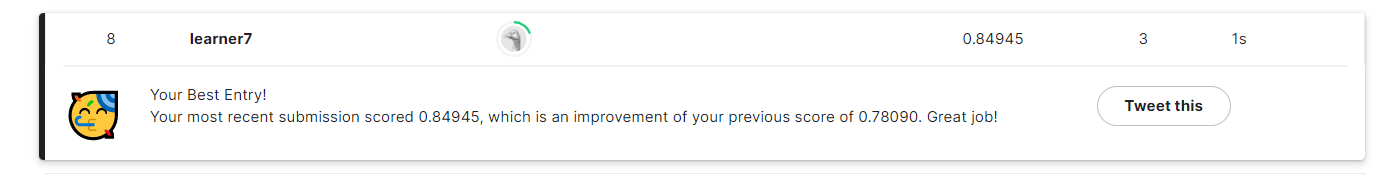

## Task 6 Answer the questions

🌈Based on the provided template, describe the format of the input file (sdf file).

The input file is a data structure file (SDF). It includes the compound's name, Atom count, version number, connections, and label are also shown. The atom block describes the constituents of the chemical. The edge block describes the compound's bonding structure. Both of these blocks are used to obtain information about the compound and save it in the form of edges and nodes. Each node represents an atom from the chemical molecule. Different compounds are distinguished by doller signs


🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

nodes: Since the nodes' data are preprocessed before being sent into the network, the chemical compound information for each node is in tokenized form. Each batch has the form [batch size*max len nodes], where batch size is the number of samples and max len nodes is the length of tokenized nodes after padding.

edge: edge is the input tensor containing information about the interatomic bonding structure. The edge has the form [sum of all edges,2]. The sum of all edges is determined by summing the total number of edges for each sample in a batch.

node2graph:  It is the input tensor that stores information about segmented ids. Each batch's shape is [batch size*max len nodes], where batch size is the number of samples in the batch and max len nodes is the length of tokenized nodes after padding.



🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

**gnn_out:** (batch size node dimension,hidden layers) is the shape of gnn out, where batch size node dimension is the tokenized vector dimension of the whole batch.



**avg:** Based on the segmented ids, verage computes the segmented mean of the gnn out. The segment mean takes the mean of all the gnn out output data and represents one sample with one integer for each hidden layer. The average tensor's final output has the form [batch size, hidden layer]. It is a method of gathering information for each sample and interpreting it as mean data.


🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

segment_mean takes the mean of the data which have same segmented ids.

reduce_mean  computes the mean of elements across dimensions of a tensor.

🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?


 the GNN model from the template is implemented with  the default setting of 4  layers. The default message passing method is rgcn (Graph convolution layers). Using multiple gcn facilitates the incorporation of all graph complexity.



